In [1]:
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

Rated_Capacity = 1.1

# 1. 加载数据

In [2]:
def drop_outlier(array, count, bins):
    index = []
    range_ = np.arange(1, count, bins)
    for i in range_[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma * 2, mean - sigma * 2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_instances(sequence, window_size):
    # sequence: list of capacity
    x, y = [], []
    for i in range(len(sequence) - window_size):
        features = sequence[i : i + window_size]
        target = sequence[i + window_size]

        x.append(features)
        y.append(target)

    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    data_sequence = data_dict[name]["capacity"]
    train_data, test_data = (
        data_sequence[: window_size + 1],
        data_sequence[window_size + 1 :],
    )
    train_x, train_y = build_instances(train_data, window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_instances(v["capacity"], window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i - 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return (
        abs(true_re - pred_re) / true_re if abs(true_re - pred_re) / true_re <= 1 else 1
    )


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse


def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ["PYTHONHASHSEED"] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(
            seed
        )  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 1.1 提取所需特征

In [5]:
Battery_list = ["CS2_35", "CS2_36", "CS2_37", "CS2_38"]

dir_path = "dataset/"
Battery = {}
for name in Battery_list:
    print("Load Dataset " + name + " ...")
    path = glob.glob(dir_path + name + "/*.xlsx")
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print("Load " + str(p) + " ...")
        dates.append(df["Date_Time"][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print("Load " + str(p) + " ...")
        cycles = list(set(df["Cycle_Index"]))
        for c in cycles:
            df_lim = df[df["Cycle_Index"] == c]
            # Charging
            df_c = df_lim[(df_lim["Step_Index"] == 2) | (df_lim["Step_Index"] == 4)]
            c_v = df_c["Voltage(V)"]
            c_c = df_c["Current(A)"]
            c_t = df_c["Test_Time(s)"]
            # CC or CV
            df_cc = df_lim[df_lim["Step_Index"] == 2]
            df_cv = df_lim[df_lim["Step_Index"] == 4]
            CCCT.append(np.max(df_cc["Test_Time(s)"]) - np.min(df_cc["Test_Time(s)"]))
            CVCT.append(np.max(df_cv["Test_Time(s)"]) - np.min(df_cv["Test_Time(s)"]))

            # Discharging
            df_d = df_lim[df_lim["Step_Index"] == 7]
            d_v = df_d["Voltage(V)"]
            d_c = df_d["Current(A)"]
            d_t = df_d["Test_Time(s)"]
            d_im = df_d["Internal_Resistance(Ohm)"]

            if len(list(d_c)) != 0:
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff * d_c / 3600  # Q = A*h
                discharge_capacity = [
                    np.sum(discharge_capacity[:n])
                    for n in range(discharge_capacity.shape[0])
                ]
                discharge_capacities.append(-1 * discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame(
        {
            "cycle": np.linspace(1, idx.shape[0], idx.shape[0]),
            "capacity": discharge_capacities[idx],
            "SoH": health_indicator[idx],
            "resistance": internal_resistance[idx],
            "CCCT": CCCT[idx],
            "CVCT": CVCT[idx],
        }
    )
    Battery[name] = df_result

Load Dataset CS2_35 ...
Load dataset/CS2_35\CS2_35_10_15_10.xlsx ...
Load dataset/CS2_35\CS2_35_10_22_10.xlsx ...
Load dataset/CS2_35\CS2_35_10_29_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_01_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_08_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_23_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_24_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_06_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_13_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_20_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_23_10.xlsx ...
Load dataset/CS2_35\CS2_35_1_10_11.xlsx ...
Load dataset/CS2_35\CS2_35_1_18_11.xlsx ...
Load dataset/CS2_35\CS2_35_1_24_11.xlsx ...
Load dataset/CS2_35\CS2_35_1_28_11.xlsx ...
Load dataset/CS2_35\CS2_35_2_10_11.xlsx ...
Load dataset/CS2_35\CS2_35_2_4_11.xlsx ...
Load dataset/CS2_35\CS2_35_8_17_10.xlsx ...
Load dataset/CS2_35\CS2_35_8_18_10.xlsx ...
Load dataset/CS2_35\CS2_35_8_19_10.xlsx ...
Load dataset/CS2_35\CS2_35_8_30_10.xlsx ...
Load dataset/CS2_35\CS2_35_9_21_10.xlsx ..

**或者**

## 1.1 加载已经提取完成的数据

**如果上面的读取数据集失败，可以通过下面的方式加载已提取出来的数据**

In [ ]:
Battery_list = ["CS2_35", "CS2_36", "CS2_37", "CS2_38"]
Battery = np.load("dataset/CALCE.npy", allow_pickle=True)
Battery = Battery.item()

## 1.2 画容量衰减曲线

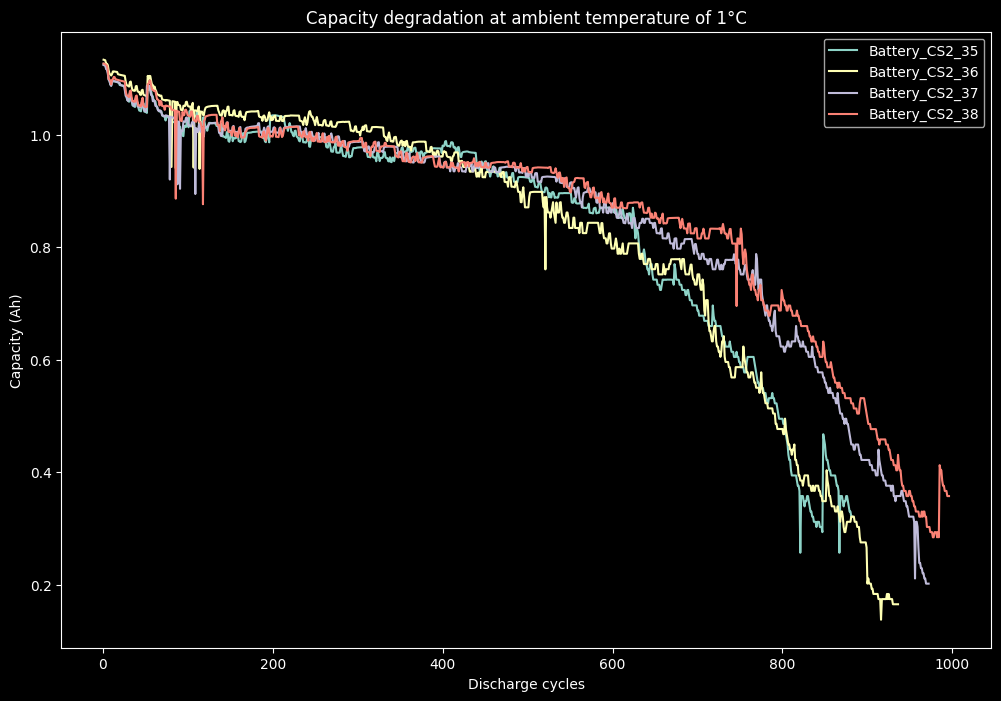

In [7]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
# color_list = ["b:", "g--", "r-.", "c."]
for name in Battery_list:
    df_result = Battery[name]
    ax.plot(df_result["cycle"], df_result["capacity"], label="Battery_" + name)
ax.set(
    xlabel="Discharge cycles",
    ylabel="Capacity (Ah)",
    title="Capacity degradation at ambient temperature of 1°C",
)
plt.legend()

# 2. 建立模型及其训练

## 2.1 建立模型

In [25]:
# Function to build ARIMA model instances
def build_arima_instances(sequence, train_ratio=0.8):
    train_size = int(len(sequence) * train_ratio)
    train_data, test_data = sequence[:train_size], sequence[train_size:]
    return train_data, test_data

## 2.2 训练

In [29]:
# Use auto_arima for optimal order selection
from pmdarima import auto_arima

def train_arima_auto(data_dict, name, train_ratio=0.8, forecast_steps=10):
    sequence = data_dict[name]["capacity"]
    train_size = int(len(sequence) * train_ratio)
    train_data, test_data = sequence[:train_size], sequence[train_size:]

    # Train ARIMA with auto-order detection
    print(f"Tuning ARIMA parameters for {name}...")
    model = auto_arima(train_data, seasonal=False, trace=True, suppress_warnings=True)
    print(model.summary())

    # Forecast on test set
    test_predictions = model.predict(n_periods=len(test_data))

    # Retrain on full data for future prediction
    print(f"Retraining on full dataset for {name}...")
    model_full = auto_arima(sequence, seasonal=False)
    future_predictions = model_full.predict(n_periods=forecast_steps)

    return train_data, test_data, test_predictions, sequence, future_predictions

# # Function to split data into train/test and retrain for prediction
# def train_and_predict_arima(data_dict, name, order=(1, 1, 1), train_ratio=0.8, forecast_steps=10):
#     sequence = data_dict[name]["capacity"]
    
#     # Split data into train and test sets
#     train_size = int(len(sequence) * train_ratio)
#     train_data, test_data = sequence[:train_size], sequence[train_size:]
    
#     # Ensure train_data is not empty
#     if len(train_data) == 0:
#         raise ValueError(f"Train data for {name} is empty. Check the sequence or train-test split ratio.")
    
#     # Fit ARIMA model on the training set
#     print(f"Training ARIMA for {name} (train/test split)...")
#     diff_train_data = np.diff(train_data)
#     model = ARIMA(diff_train_data, order=order)
#     model_fit = model.fit()
#     print(model_fit.summary())
    
#     # Forecast test set values
#     diff_predictions = model_fit.forecast(steps=len(test_data))
#     test_predictions = np.cumsum(diff_predictions) + train_data.iloc[-1]
#     rmse = np.sqrt(mean_squared_error(test_data, test_predictions))
#     print(f"RMSE for {name}: {rmse:.4f}")
    
#     # Retrain on the full dataset and forecast future values
#     print(f"Retraining ARIMA on the entire dataset for {name}...")
#     diff_sequence = np.diff(sequence)
#     full_model = ARIMA(diff_sequence, order=order)
#     full_model_fit = full_model.fit()
#     future_diff_forecast = full_model_fit.forecast(steps=forecast_steps)
#     future_predictions = np.cumsum(future_diff_forecast) + sequence.iloc[-1]

#     return train_data, test_data, test_predictions, rmse, sequence, future_predictions

## 2.3 画预测曲线

In [36]:
# Function to visualize results
def draw_arima_final_results(train_data, test_data, test_predictions, sequence, future_predictions, title="ARIMA Final Results"):
    plt.figure(figsize=(14, 7))
    
    # Plot actual data
    plt.plot(range(len(sequence)), sequence, label="Actual Data")
    
    # Plot train/test split
    plt.axvline(len(train_data), linestyle="--", label="Train/Test Split")
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_predictions, label="Test Predictions")
    
    # Plot future predictions
    plt.plot(
        range(len(sequence), len(sequence) + len(future_predictions)),
        future_predictions,
        label="Future Forecast",
    )
    
    plt.xlabel("Cycles")
    plt.ylabel("Capacity (Ah)")
    plt.title(title)
    plt.legend()
    plt.show()

Tuning ARIMA parameters for CS2_35...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5145.019, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5116.146, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5114.611, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5114.601, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5111.165, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5145.450, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5147.436, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5152.963, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5149.790, Time=1.37 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-5152.547, Time=0.40 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-5154.856, Time=0.74 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-5145.356, Time=0.45 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-5152.425, Time=1.06 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-5151.

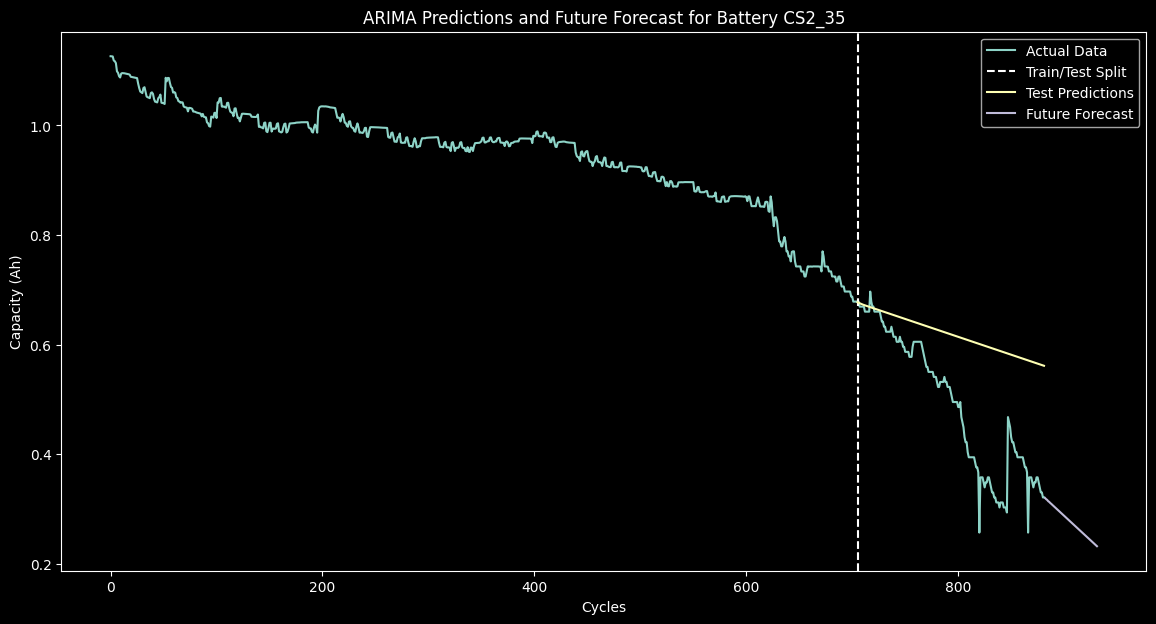

Tuning ARIMA parameters for CS2_36...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4319.471, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4136.506, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4220.510, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4305.538, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4136.761, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4321.178, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4323.182, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4319.506, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4321.957, Time=0.97 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4319.624, Time=1.52 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4307.667, Time=0.33 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 5.840 seconds
                               SARIMAX Results                                
Dep. Variable:            

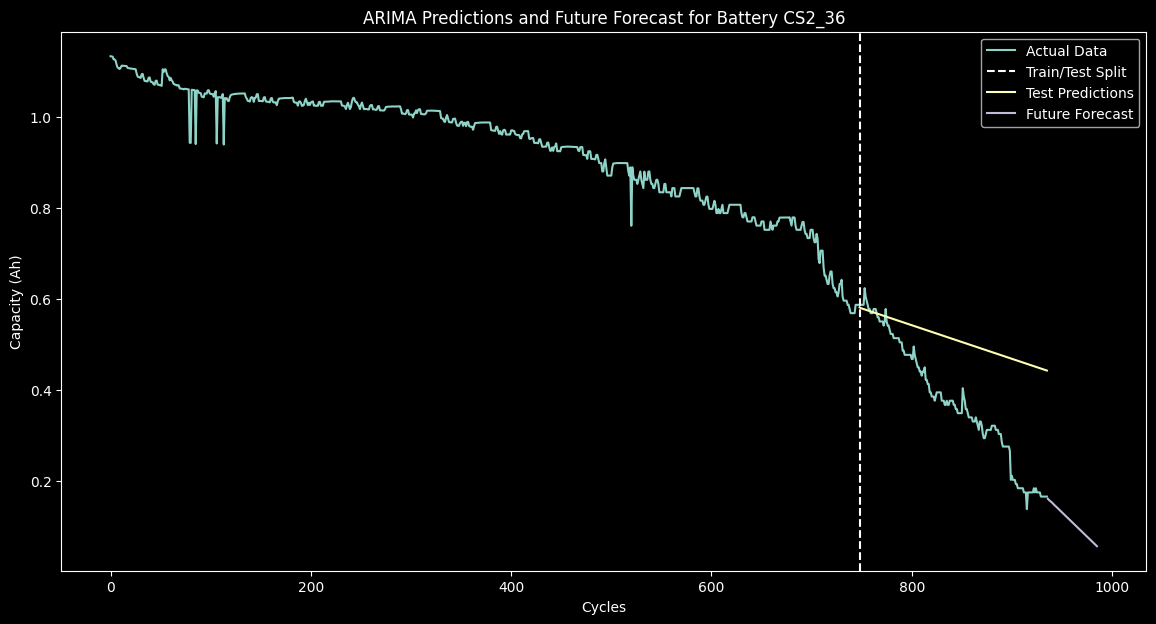

Tuning ARIMA parameters for CS2_37...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4755.380, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4511.870, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4622.910, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4740.927, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4512.574, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4759.455, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4754.372, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4735.976, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4761.043, Time=1.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4755.740, Time=1.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4758.749, Time=0.91 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-4764.956, Time=0.67 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-4768.625, Time=1.80 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-4766.

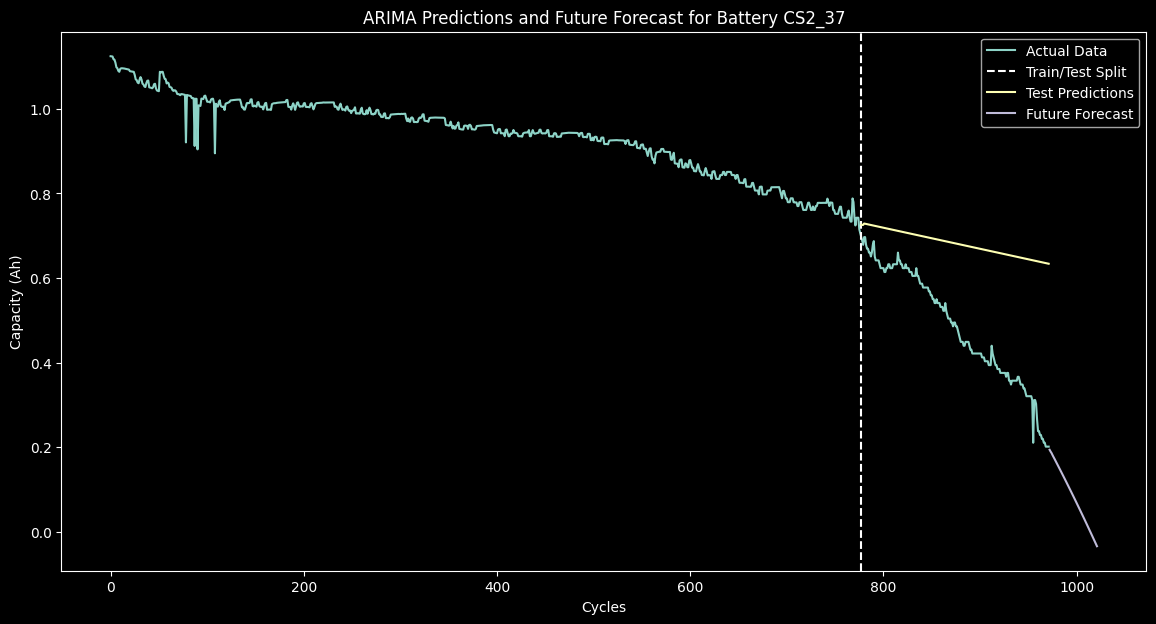

Tuning ARIMA parameters for CS2_38...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4782.310, Time=1.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4570.868, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4688.697, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4775.711, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4571.560, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4778.800, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4778.950, Time=0.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4780.829, Time=1.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4764.685, Time=1.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4783.022, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4785.625, Time=0.55 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4784.518, Time=2.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4782.039, Time=2.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4773.

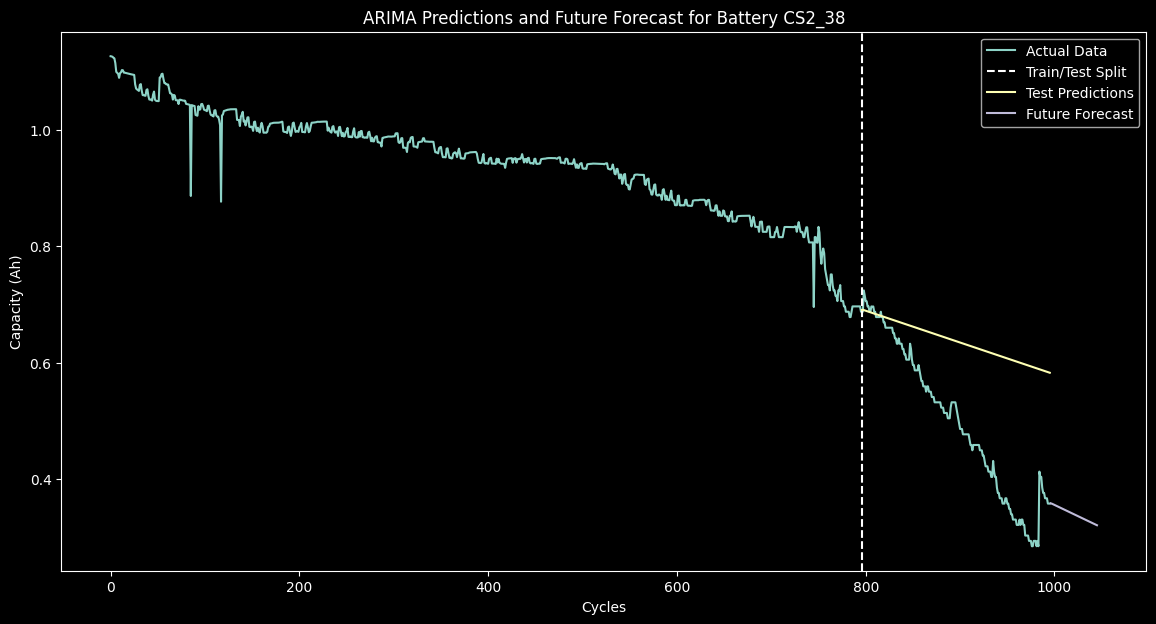

In [37]:
# Example usage
forecast_steps = 50  # Number of steps to forecast after the last data point
order = (1, 1, 1)    # ARIMA order (p, d, q)

for name in Battery_list:
    (
        train_data,
        test_data,
        test_predictions,
        sequence,
        future_predictions,
    ) = train_arima_auto(Battery, name, forecast_steps=forecast_steps)
    
    draw_arima_final_results(
        train_data,
        test_data,
        test_predictions,
        sequence,
        future_predictions,
        title=f"ARIMA Predictions and Future Forecast for Battery {name}",
    )